In [42]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import geopandas as gpd
import xarray as xr

from scipy.stats import linregress


In [32]:
# Read the bluff edge baseline into a GeoDataFrame (as a reference for the coastal retreat)
gdf_sl_bl = gpd.read_file('raw_datasets/gibbs/BarterIsland_ShoreLineBaseline.zip').to_crs(epsg=26907)

In [33]:
# csv file containing transects with bathymetric data for Barter island (measured in 2010-2011)
df = pd.read_csv("raw_datasets/erikson/Beachprofiledat/BTI_20102011BeachProfiles_Data.csv")

# use only central barter island
df = df[df.Site=="Central Barter Island"]

# convert to geodataframe
gdf_beach_profiles = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326").to_crs(epsg=26907)

In [15]:
# csv file containing bathymetric data (i.e., depth relative to MSL and absolute water depth at time of measurement) obtained trough different systems (measured between 2010 and 2011)
df_bath = pd.read_csv("raw_datasets/erikson/Single_beambath/BTI_20102011Bathymetry_Data.csv")


# Let us use only the relevant values on the northern shore of central barter island
mask = (df_bath.SYSTEM=='Humminbird') * (df_bath["Longitude"] > -143.75) * (df_bath["Longitude"] < -143.6) * (df_bath["Latitude"] > 70.12)
df_bath = df_bath[mask]

gdf_bath = gpd.GeoDataFrame(df_bath, geometry=gpd.points_from_xy(df_bath.Longitude.values, df_bath.Latitude.values, crs=4326)).to_crs(epsg=26907)

In [16]:
print(gdf_sl_bl.crs)
print(gdf_beach_profiles.crs)
print(gdf_bath.crs)

EPSG:26907
EPSG:26907
EPSG:26907


In [26]:
gdf_beach_profiles.head()

,TransectID,Longitude,Latitude,Northing,Easting,AcquireDate,CumlDist_m,Ht_Ell,Ht_MSL,Site,geometry
0,BTI-T1,-143.624821,70.133355,7782889.16,400474.51,27-Aug-10,0.00,6.11,8.41,Central Barter Island,POINT (400474.511 7782889.157)
1,BTI-T1,-143.624825,70.133377,7782891.62,400474.48,27-Aug-10,2.46,5.83,8.13,Central Barter Island,POINT (400474.466 7782891.615)
2,BTI-T1,-143.624821,70.133395,7782893.58,400474.72,27-Aug-10,4.43,5.61,7.91,Central Barter Island,POINT (400474.704 7782893.614)
3,BTI-T1,-143.624826,70.133416,7782895.98,400474.62,27-Aug-10,6.84,5.21,7.51,Central Barter Island,POINT (400474.615 7782895.962)
4,BTI-T1,-143.624826,70.133429,7782897.44,400474.69,27-Aug-10,8.30,4.69,6.99,Central Barter Island,POINT (400474.677 7782897.411)


Let's have a look.

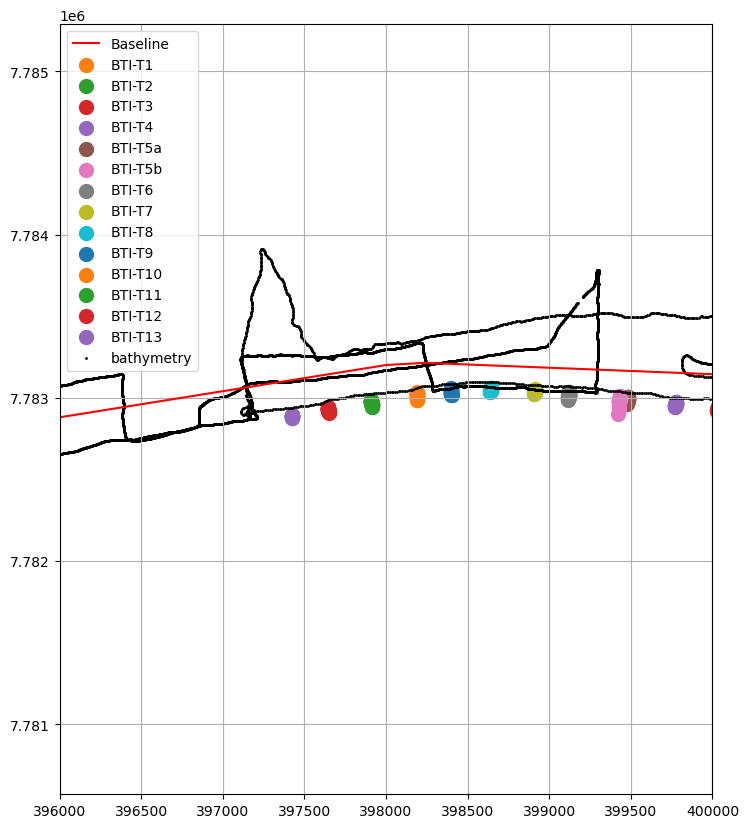

In [41]:
fig, ax = plt.subplots(figsize=(15,10))

gdf_sl_bl.plot(ax=ax, label='Baseline', color='r')

gdf_beach_profiles.plot(ax=ax)

for id in gdf_beach_profiles.TransectID.unique():
    gdf_beach_profiles[gdf_beach_profiles.TransectID==id].plot(
        ax=ax, label=id, linewidth=5, legend=True)

gdf_bath.plot(ax=ax, 
              color='k', label='bathymetry', legend=True, markersize=1)

ax.set_xlim(396000, 400000)

ax.grid()

ax.legend()

In [73]:
mask0 = ((399250, 399350), (7783000, 7783800))

mask1 = ((396320, 396450), (7782700, 7783150))
mask2 = ((397100, 397200), (7782800, 7783300))
mask3 = ((398200, 398300), (7783000, 7783400))

patch0 = Rectangle((mask0[0][0], mask0[1][0]), width=mask0[0][1]-mask0[0][0], height=mask0[1][1]-mask0[1][0],
                   facecolor=None, edgecolor='green', alpha=0.2)
patch1 = Rectangle((mask1[0][0], mask1[1][0]), width=mask1[0][1]-mask1[0][0], height=mask1[1][1]-mask1[1][0],
                   facecolor=None, edgecolor='green', alpha=0.2)
patch2 = Rectangle((mask2[0][0], mask2[1][0]), width=mask2[0][1]-mask2[0][0], height=mask2[1][1]-mask2[1][0],
                   facecolor=None, edgecolor='green', alpha=0.2)
patch3 = Rectangle((mask3[0][0], mask3[1][0]), width=mask3[0][1]-mask3[0][0], height=mask3[1][1]-mask3[1][0],
                   facecolor=None, edgecolor='green', alpha=0.2)

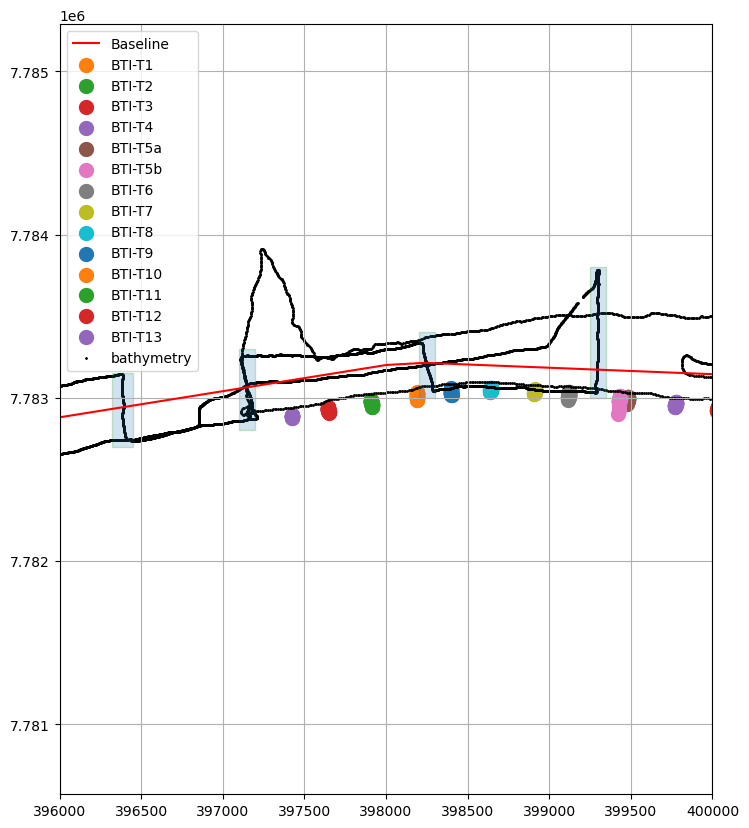

In [74]:
fig, ax = plt.subplots(figsize=(15,10))

gdf_sl_bl.plot(ax=ax, label='Baseline', color='r')

gdf_beach_profiles.plot(ax=ax)

for id in gdf_beach_profiles.TransectID.unique():
    gdf_beach_profiles[gdf_beach_profiles.TransectID==id].plot(
        ax=ax, label=id, linewidth=5, legend=True)

gdf_bath.plot(ax=ax, 
              color='k', label='bathymetry', legend=True, markersize=1)

ax.add_patch(patch0)
ax.add_patch(patch1)
ax.add_patch(patch2)
ax.add_patch(patch3)

ax.set_xlim(396000, 400000)

ax.grid()

ax.legend()

It looks like we don't really have corresponding bluffs. So let's just look at the bathymetry.

In [85]:
bathy_mask0 = (
    (gdf_bath.geometry.x > mask0[0][0]) * \
    (gdf_bath.geometry.x < mask0[0][1]) * \
    (gdf_bath.geometry.y >  mask0[1][0]) * \
    (gdf_bath.geometry.y <  mask0[1][1])
    )

bathy_mask1 = (
    (gdf_bath.geometry.x > mask1[0][0]) * \
    (gdf_bath.geometry.x < mask1[0][1]) * \
    (gdf_bath.geometry.y > mask1[1][0]) * \
    (gdf_bath.geometry.y < mask1[1][1])
    )

bathy_mask2 = (
    (gdf_bath.geometry.x > mask2[0][0]) * \
    (gdf_bath.geometry.x < mask2[0][1]) * \
    (gdf_bath.geometry.y > mask2[1][0]) * \
   ( gdf_bath.geometry.y < mask2[1][1])
    )

bathy_mask3 = (
    (gdf_bath.geometry.x > mask3[0][0]) * \
    (gdf_bath.geometry.x < mask3[0][1]) * \
    (gdf_bath.geometry.y > mask3[1][0]) * \
    (gdf_bath.geometry.y < mask3[1][1])
    )

x0 = gdf_bath[bathy_mask0].dropna().geometry.x.values
y0 = gdf_bath[bathy_mask0].dropna().geometry.y.values
z0 = gdf_bath[bathy_mask0].dropna().Depth_MSL.values * -1

x1 = gdf_bath[bathy_mask1].dropna().geometry.x.values
y1 = gdf_bath[bathy_mask1].dropna().geometry.y.values
z1 = gdf_bath[bathy_mask1].dropna().Depth_MSL.values * -1

x2 = gdf_bath[bathy_mask2].dropna().geometry.x.values
y2 = gdf_bath[bathy_mask2].dropna().geometry.y.values
z2 = gdf_bath[bathy_mask2].dropna().Depth_MSL.values * -1

x3 = gdf_bath[bathy_mask3].dropna().geometry.x.values
y3 = gdf_bath[bathy_mask3].dropna().geometry.y.values
z3 = gdf_bath[bathy_mask3].dropna().Depth_MSL.values * -1


In [86]:
print(x0)

[399252.46968085 399255.19321382 399257.54266648 399260.61211283
 399263.34050972 399265.73272    399268.80216662 399271.86675078
 399274.25409849 399277.32354568 399279.6729992  399282.39653484
 399284.11636963 399285.964473   399287.56676207 399288.9183745
 399289.59274903 399290.05920388 399289.72987842 399288.91279043
 399288.05294808 399286.79571927 399285.7843043  399284.49891084
 399283.50694876 399282.22156141 399281.26850232 399280.60887301
 399280.27084126 399280.30789086 399280.69470444 399281.14372244
 399281.59760184 399282.39252254 399282.85025774 399283.30413404
 399284.06115682 399285.07756558 399286.19406951 399287.3912195
 399288.54561145 399289.70872238 399290.8679712  399291.7949969
 399292.3897053  399292.71043945 399292.77464451 399292.60763197
 399292.47365129 399292.27260737 399291.7412551  399291.5314917
 399291.27411268 399291.06435112 399290.84486655 399290.34655253
 399290.11834971 399289.89400624 399289.62791319 399290.04774102
 399289.79623549 399290.22092

In [157]:
slope0, intercept0, _, _, _ = linregress(y0, x0)
x_fitted0 = slope0 * y0 + intercept0

slope1, intercept1, _, _, _ = linregress(y1, x1)
x_fitted1 = slope1 * y1 + intercept1

# slope2, intercept2, _, _, _ = linregress(y2, x2)
# x_fitted2 = slope2 * y2 + intercept2

slope3, intercept3, _, _, _ = linregress(y3, x3)
x_fitted3 = slope3 * y3 + intercept3

In [171]:
slope2 = (397110 - 397200) / ((7.78325 - 7.78290)*10**6)
intercept2 = 397200 - slope2 * 7.78290*10**6

x_fitted2 = y2 * slope2 + intercept2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


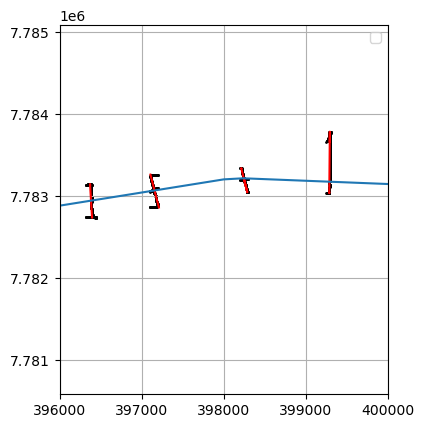

In [172]:
fig, ax = plt.subplots()

ax.scatter(x0, y0, s=1, color='k')
ax.scatter(x1, y1, s=1, color='k')
ax.scatter(x2, y2, s=1, color='k')
ax.scatter(x3, y3, s=1, color='k')

ax.plot(x_fitted0, y0, color='red')
ax.plot(x_fitted1, y1, color='red')
ax.plot(x_fitted2, y2, color='red')
ax.plot(x_fitted3, y3, color='red')

gdf_sl_bl.plot(ax=ax)

ax.set_xlim(396000, 400000)

ax.grid()

ax.legend()

Determine the zero point, i.e. the intersection of the bluff edge baseline with the fitted line.

In [173]:
from shapely.geometry import LineString

In [174]:
# sort x and y values
i2 = np.argsort(y2)
y2 = y2[i2]
x2 = x2[i2]
x_fitted2 = x_fitted2[i2]
z2 = z2[i2]

In [175]:
geoseries0 = gpd.GeoSeries([
    LineString([(x_fitted0[0], y0[0]), (x_fitted0[-1], y0[-1])]),
    gdf_sl_bl.geometry.values[0]])
intersection_point0 = geoseries0[0].intersection(geoseries0[1])

geoseries1 = gpd.GeoSeries([
    LineString([(x_fitted1[0], y1[0]), (x_fitted1[-1], y1[-1])]),
    gdf_sl_bl.geometry.values[0]])
intersection_point1 = geoseries1[0].intersection(geoseries1[1])

geoseries2 = gpd.GeoSeries([
    LineString([(x_fitted2[0], y2[0]), (x_fitted2[-1], y2[-1])]),
    gdf_sl_bl.geometry.values[0]])
intersection_point2 = geoseries2[0].intersection(geoseries2[1])

geoseries3 = gpd.GeoSeries([
    LineString([(x_fitted3[0], y3[0]), (x_fitted3[-1], y3[-1])]),
    gdf_sl_bl.geometry.values[0]])
intersection_point3 = geoseries3[0].intersection(geoseries3[1])

In [176]:
print(intersection_point0)
print(intersection_point1)
print(intersection_point2)
print(intersection_point3)

POINT (399289.6450876258 7783172.502457827)
POINT (396383.29064998904 7782941.559344295)
POINT (397157.4242136571 7783065.5725024445)
POINT (398246.216786946 7783213.857845349)


In [177]:
print(type(intersection_point0))
print(type(intersection_point1))
print(type(intersection_point2))
print(type(intersection_point3))

<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.point.Point'>


In [178]:
def project_point_onto_line(point, origin, line_direction):
    # Calculate the vector from the origin to the point
    vec_to_point = point - origin
    # Calculate the scalar projection of the vector onto the line direction
    scalar_projection = np.dot(vec_to_point, line_direction) / np.dot(line_direction, line_direction)
    # Calculate the projected point
    projected_point = origin + scalar_projection * line_direction
    
    return projected_point

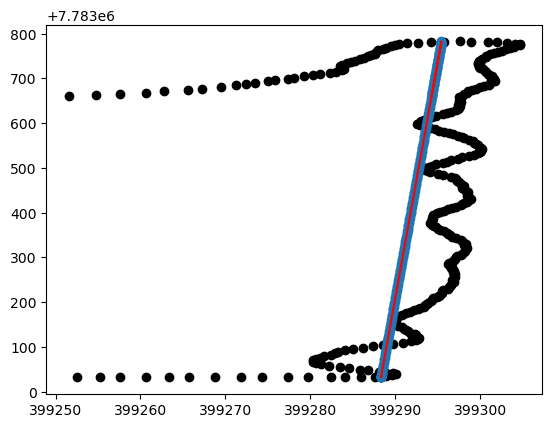

In [179]:
projected_points0 = []

for x, y, z in zip(x0, y0, z0):
    projected_point0 = project_point_onto_line(
        np.array((x, y)), 
        np.array((intersection_point0.x, intersection_point0.y)), 
        np.array([slope0, 1])
        )
    projected_points0.append(projected_point0)
projected_points0 = np.array(projected_points0)

plt.plot(x_fitted0, y0, color='r')
plt.scatter(x0, y0, color='k')
plt.scatter(projected_points0[:,0],projected_points0[:,1], color='C0')

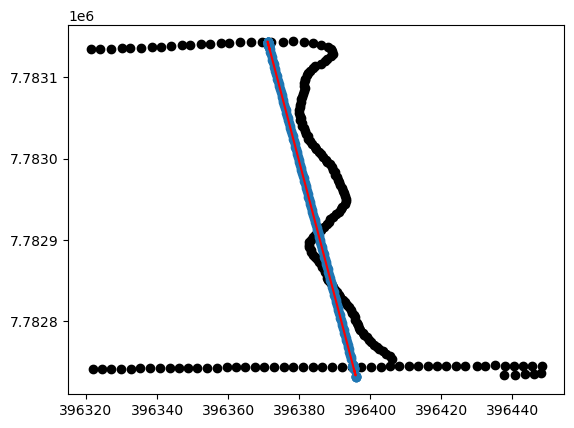

In [180]:
projected_points1 = []

for x, y, z in zip(x1, y1, z1):
    projected_point1 = project_point_onto_line(
        np.array((x, y)), 
        np.array((intersection_point1.x, intersection_point1.y)), 
        np.array([slope1, 1])
        )
    projected_points1.append(projected_point1)
projected_points1 = np.array(projected_points1)

plt.plot(x_fitted1, y1, color='r')
plt.scatter(x1, y1, color='k')
plt.scatter(projected_points1[:,0],projected_points1[:,1], color='C0')

217


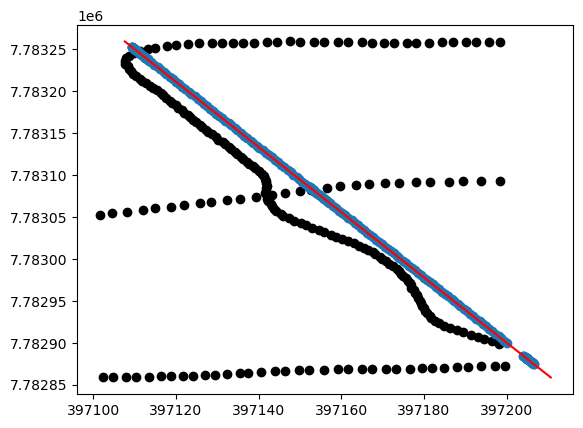

In [193]:
projected_points2 = []

print(len(x2))

for x, y, z in zip(x2, y2, z2):
    projected_point2 = project_point_onto_line(
        np.array((x, y)), 
        np.array((intersection_point2.x, intersection_point2.y)), 
        np.array([slope2, 1])
        )
    projected_points2.append(projected_point2)
projected_points2 = np.array(projected_points2)

plt.plot(x_fitted2, y2, color='r')
plt.scatter(x2, y2, color='k')
plt.scatter(projected_points2[:,0],projected_points2[:,1], color='C0')

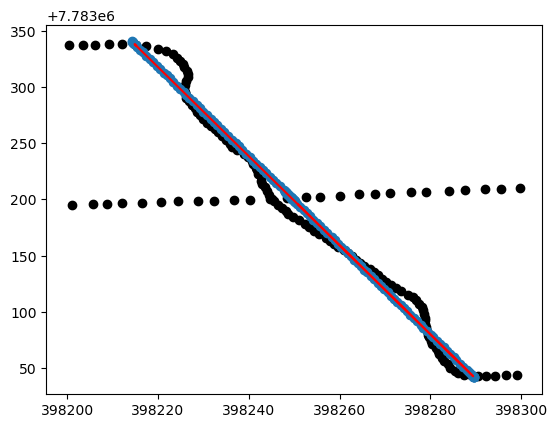

In [182]:
projected_points3 = []

for x, y, z in zip(x3, y3, z3):
    projected_point3 = project_point_onto_line(
        np.array((x, y)), 
        np.array((intersection_point3.x, intersection_point3.y)), 
        np.array([slope3, 1])
        )
    projected_points3.append(projected_point3)
projected_points3 = np.array(projected_points3)

plt.plot(x_fitted3, y3, color='r')
plt.scatter(x3, y3, color='k')
plt.scatter(projected_points3[:,0],projected_points3[:,1], color='C0')

We don't care too much about orientation right now.

Now we can compute the distance to the origin for each point, and finally get the 1D coordinate system.

In [194]:
coords0 = []
for x_proj, y_proj, z in zip(projected_points0[:,0], projected_points0[:,1], z0):
    distance = np.sqrt((x_proj - intersection_point0.x)**2 + (y_proj - intersection_point0.y)**2)
    if x_proj < intersection_point0.x:
        distance *= -1
    coords0.append(distance)
coords0 = np.array(coords0)

coords1 = []
for x_proj, y_proj, z in zip(projected_points1[:,0], projected_points1[:,1], z1):
    distance = np.sqrt((x_proj - intersection_point1.x)**2 + (y_proj - intersection_point1.y)**2)
    if x_proj < intersection_point1.x:
        distance *= -1
    coords1.append(distance)
coords1 = np.array(coords1)

coords2 = []
for x_proj, y_proj, z in zip(projected_points2[:,0], projected_points2[:,1], z2):
    distance = np.sqrt((x_proj - intersection_point2.x)**2 + (y_proj - intersection_point2.y)**2)
    if x_proj < intersection_point2.x:
        distance *= -1
    coords2.append(distance)
coords2 = np.array(coords2)

coords3 = []
for x_proj, y_proj, z in zip(projected_points3[:,0], projected_points3[:,1], z3):
    distance = np.sqrt((x_proj - intersection_point3.x)**2 + (y_proj - intersection_point3.y)**2)
    if x_proj < intersection_point3.x:
        distance *= -1
    coords3.append(distance)
coords3 = np.array(coords3)

In [201]:
sort_indices0 = np.argsort(coords0)
sorted_coords0 = coords0[sort_indices0]
sorted_z0 = z0[sort_indices0]

sort_indices1 = np.argsort(coords1)
sorted_coords1 = coords1[sort_indices1] * -1  # due to direction of transect, the coordinates come out as negative and positive being switched
sorted_z1 = z1[sort_indices1]

sort_indices2 = np.argsort(coords2)
sorted_coords2 = coords2[sort_indices2] * -1  # due to direction of transect, the coordinates come out as negative and positive being switched
sorted_z2 = z2[sort_indices2]

sort_indices3 = np.argsort(coords3)
sorted_coords3 = coords3[sort_indices3] * -1  # due to direction of transect, the coordinates come out as negative and positive being switched
sorted_z3 = z3[sort_indices3]

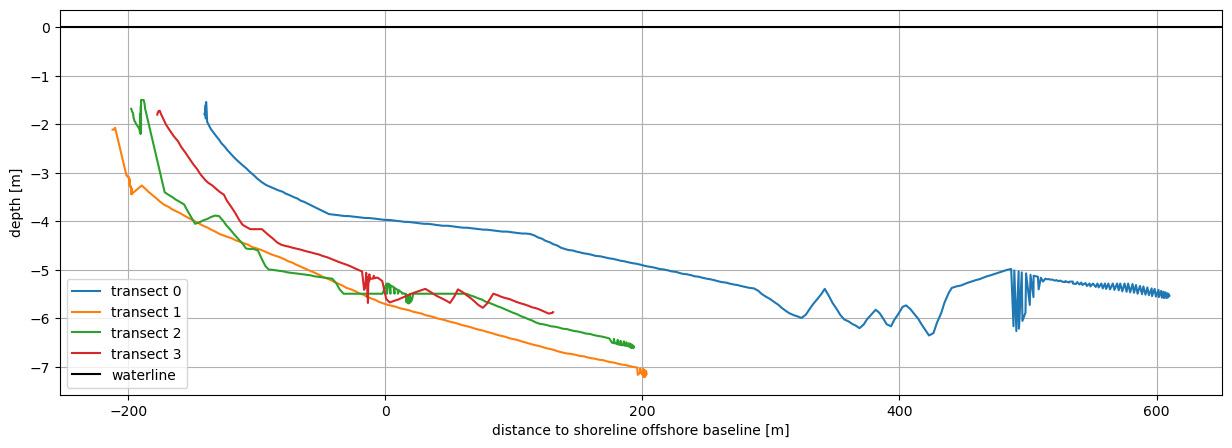

In [202]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(sorted_coords0, sorted_z0, label="transect 0")
ax.plot(sorted_coords1, sorted_z1, label="transect 1")
ax.plot(sorted_coords2, sorted_z2, label="transect 2")
ax.plot(sorted_coords3, sorted_z3, label="transect 3")

ax.axhline(0, sorted_coords0[0], sorted_coords0[-1], color='k', label='waterline')

ax.set_xlabel("distance to shoreline offshore baseline [m]")
ax.set_ylabel("depth [m]")

ax.grid()

ax.legend()

Let's try to anchor all beaches to the same point at x=0.

In [208]:
sorted_coords0_aug = sorted_coords0 - sorted_coords0[0]
sorted_coords1_aug = sorted_coords1 - sorted_coords1[-1]
sorted_coords2_aug = sorted_coords2 - sorted_coords2[-1]
sorted_coords3_aug = sorted_coords3 - sorted_coords3[-1]

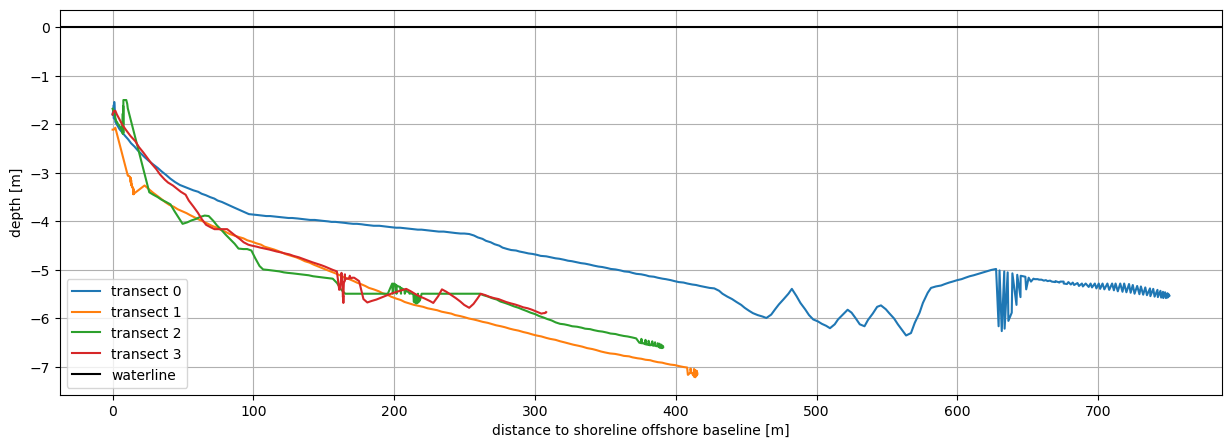

In [209]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(sorted_coords0_aug, sorted_z0, label="transect 0")
ax.plot(sorted_coords1_aug, sorted_z1, label="transect 1")
ax.plot(sorted_coords2_aug, sorted_z2, label="transect 2")
ax.plot(sorted_coords3_aug, sorted_z3, label="transect 3")

ax.axhline(0, sorted_coords0[0], sorted_coords0[-1], color='k', label='waterline')

ax.set_xlabel("distance to shoreline offshore baseline [m]")
ax.set_ylabel("depth [m]")

ax.grid()

ax.legend()

Apparently, the profile that I have been considering is a bit less steep. For now, let's just go with that...